<a href="https://colab.research.google.com/github/sathakshi03/Sathakshi-FMML_2023/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-07 05:48:30--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.173.166.45, 18.173.166.66, 18.173.166.15, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.173.166.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   112MB/s    in 0.4s    

2024-05-07 05:48:31 (112 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


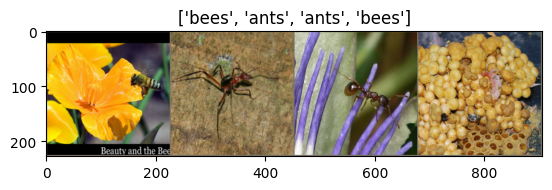

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 110MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.6812 Acc: 0.6557

Epoch 1/4
----------
Loss: 0.3946 Acc: 0.8238

Epoch 2/4
----------
Loss: 0.5086 Acc: 0.7787

Epoch 3/4
----------
Loss: 0.3475 Acc: 0.8402

Epoch 4/4
----------
Loss: 0.5770 Acc: 0.7705



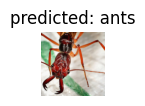

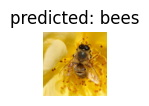

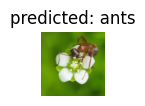

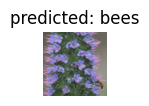

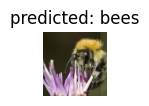

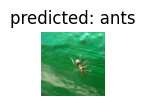

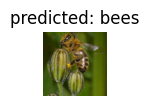

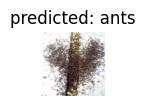

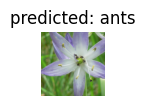

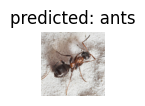

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


1.Data augmentation techniques like resizing, cropping, rotating, flipping, and adding noise to training data are significant in machine learning for several reasons:

Increased Robustness: Augmenting data helps in creating a more robust model by exposing it to variations in the input data. For example, resizing images to different scales or cropping them randomly simulates different viewpoints or zoom levels, making the model more resilient to variations in input during inference.
Improved Generalization: Data augmentation helps prevent overfitting by introducing variations in the training data. When the model sees different variations of the same data, it learns to generalize better to unseen examples.
Increased Training Data: By applying augmentations, you effectively increase the size of your training dataset without actually collecting more data. This can be particularly useful when working with limited data, as it helps prevent the model from memorizing the training examples.
Regularization: Data augmentations act as a form of regularization, similar to dropout or weight decay. They introduce noise and variations during training, which can help prevent the model from fitting noise in the training data too closely.

2.If you train a ResNet model without using pretraining (i.e., setting pretrained=False), the performance can vary significantly depending on several factors:

Dataset Size: A larger dataset can compensate for the lack of pretraining to some extent. With more diverse and abundant data, the model has a better chance of learning meaningful representations even without pretraining.
Task Complexity: For simpler tasks or tasks with clear patterns, training from scratch may yield reasonable performance. However, for complex tasks like image recognition on large datasets, pretrained models often provide better starting points due to their learned feature representations.
Computational Resources: Training a deep neural network like ResNet from scratch requires substantial computational resources, including GPU time and memory. Without pretrained weights, the training process may take longer and require more data to achieve comparable performance.
Regularization Techniques: When training from scratch, employing regularization techniques such as data augmentation, dropout, and weight decay becomes crucial to prevent overfitting and improve generalization.
Hyperparameters: The choice of hyperparameters, including learning rate, batch size, optimizer, and training duration, can significantly impact the model's final performance when training without pretraining.

3.Using a ResNet model pretrained on a significantly different dataset than the ants vs bees data may or may not lead to good performance. It depends on several factors:

Domain Similarity: If the pretrained dataset is somewhat related to the ants vs bees data (e.g., both are natural image datasets), the pretrained model can still learn useful features that generalize well to the new task. For example, features like edges, textures, and shapes are common across many image domains.
Transferability of Features: Deep learning models like ResNet are designed to learn hierarchical features that are often transferable across different tasks and domains. Lower layers tend to capture low-level features like edges and textures, which are generally applicable, while higher layers capture more task-specific features.
Fine-tuning: Fine-tuning the pretrained model on the new dataset can further improve performance. By adjusting the model's weights during training on the new data, it can adapt its learned representations to better suit the specific characteristics of the ants vs bees dataset.
Data Augmentation and Regularization: Utilizing data augmentation and regularization techniques can also help the pretrained model generalize better to the new dataset by preventing overfitting and enhancing robustness.
Dataset Size: The size and diversity of the new dataset play a crucial role. A larger and more diverse dataset provides more information for the model to learn task-specific nuances, potentially compensating for differences between the pretrained and target domains.